# Binary Classification for insurance cross selling
## Playground Series - Season 4, Episode 7
Overview: https://www.kaggle.com/competitions/playground-series-s4e7/overview


## 0) Intro -  Objective 


Your Goal: The objective of this competition is to predict which customers respond positively to an automobile insurance offer.

Submissions are evaluated using area under the ROC curve using the predicted probabilities and the ground truth targets.

## 1) Import of packages

In [4]:
import numpy as np # linear algebra
import optuna
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMClassifier

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.kernel_approximation import Nystroem
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import QuantileTransformer
from sklearn import metrics
from sklearn.linear_model import LogisticRegression


from catboost import CatBoostClassifier

from sklearn.model_selection import GridSearchCV
from feature_engine.encoding import OneHotEncoder
pd.set_option('mode.chained_assignment', None)

from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import os
for dirname, _, filenames in os.walk('data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


pd.set_option('display.max_rows', None)

#!pip install -U seaborn

optuna.logging.set_verbosity(optuna.logging.WARNING)

data/test.csv
data/train.csv


## 1) Load the data and check structure

In [22]:
train_data = pd.read_csv("data/train.csv", index_col='id')
test_data = pd.read_csv("data/test.csv", index_col='id')

print(train_data.shape, test_data.shape)


(11504798, 11) (7669866, 10)


#### There are numerical and categorical variables

In [16]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11504798 entries, 0 to 11504797
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Gender                object 
 1   Age                   int64  
 2   Driving_License       int64  
 3   Region_Code           float64
 4   Previously_Insured    int64  
 5   Vehicle_Age           object 
 6   Vehicle_Damage        object 
 7   Annual_Premium        float64
 8   Policy_Sales_Channel  float64
 9   Vintage               int64  
 10  Response              int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 1.0+ GB


In [17]:
train_data.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [18]:
print(train_data.columns, f"There are {len(train_data.columns)} columns")

Index(['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object') There are 11 columns


In [19]:
train_data.Vehicle_Age.unique()

array(['1-2 Year', '> 2 Years', '< 1 Year'], dtype=object)

In [20]:
train_data.Region_Code.unique()

array([35. , 28. , 14. ,  1. , 15. , 47. , 45. ,  8. , 11. ,  3. , 10. ,
       12. , 37. , 50. , 30. , 46. , 29. , 16. , 26. , 25. , 41. , 48. ,
        7. ,  4. , 24. , 36. , 33. ,  2. ,  9. , 27. , 18. , 43. , 49. ,
       17. , 13. , 38. ,  6. , 21. , 23. ,  0. , 19. ,  5. , 39. , 44. ,
       20. , 40. , 22. , 32. , 42. , 31. , 34. , 51. , 52. , 39.2])

In [23]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

### Use Label Encoding for ordinal data where the order matters
for variable in ["Vehicle_Age"]:
    label_encoder = LabelEncoder()
    label_encoder.fit(train_data[variable])

    train_data[f'{variable}_Encoded'] = label_encoder.transform(train_data[variable])
    test_data[f'{variable}_Encoded'] = label_encoder.transform(test_data[variable])
    train_data = train_data.drop(columns=[variable])
    test_data = test_data.drop(columns=[variable])

### Use `pandas.get_dummies` for one-hot encoding for nominal data
nominal_variables = ["Gender", "Vehicle_Damage", "Region_Code"]

# Convert 'Region_Code' to string
train_data['Region_Code'] = train_data['Region_Code'].astype(str)
test_data['Region_Code'] = test_data['Region_Code'].astype(str)

# Concatenate train and test data for consistent encoding
all_data = pd.concat([train_data, test_data], keys=['train', 'test'])

# Apply one-hot encoding
all_data = pd.get_dummies(all_data, columns=nominal_variables, dtype='int')

# Separate the train and test data
train_data = all_data.xs('train')
test_data = all_data.xs('test')


In [24]:
test_data.head()

,Age,Driving_License,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Vehicle_Age_Encoded,Gender_Female,Gender_Male,...,Region_Code_48.0,Region_Code_49.0,Region_Code_5.0,Region_Code_50.0,Region_Code_51.0,Region_Code_52.0,Region_Code_6.0,Region_Code_7.0,Region_Code_8.0,Region_Code_9.0
id,,,,,,,,,,,,,,,,,,,,,
11504798,20,1,0,2630.0,160.0,228,NaN,1,1,0,...,0,0,0,0,0,0,0,0,0,0
11504799,47,1,0,37483.0,124.0,123,NaN,0,0,1,...,0,0,0,0,0,0,0,0,0,0
11504800,47,1,0,2630.0,26.0,271,NaN,0,0,1,...,0,0,0,0,0,0,0,0,0,0
11504801,22,1,1,24502.0,152.0,115,NaN,1,1,0,...,0,0,0,0,0,0,0,0,0,0
11504802,51,1,0,34115.0,124.0,148,NaN,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [25]:
FEATURES = list(set(train_data.columns)-set(["Response"]))
TARGET = 'Response'  

## 3) Discover and visualize data to gain insights

##### No missing data

In [28]:
train_data.isnull().sum()

Age                     0
Driving_License         0
Previously_Insured      0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
Vehicle_Age_Encoded     0
Gender_Male             0
Gender_Female           0
Vehicle_Damage_Yes      0
Vehicle_Damage_No       0
Region_Code_35.0        0
Region_Code_28.0        0
Region_Code_14.0        0
Region_Code_1.0         0
Region_Code_15.0        0
Region_Code_47.0        0
Region_Code_45.0        0
Region_Code_8.0         0
Region_Code_11.0        0
Region_Code_3.0         0
Region_Code_10.0        0
Region_Code_12.0        0
Region_Code_37.0        0
Region_Code_50.0        0
Region_Code_30.0        0
Region_Code_46.0        0
Region_Code_29.0        0
Region_Code_16.0        0
Region_Code_26.0        0
Region_Code_25.0        0
Region_Code_41.0        0
Region_Code_48.0        0
Region_Code_7.0         0
Region_Code_4.0         0
Region_Code_24.0        0
Region_Code_36.0        0
Region_Code_

In [29]:
test_data.isnull().sum()

Age                     0
Driving_License         0
Previously_Insured      0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Vehicle_Age_Encoded     0
Gender_Male             0
Gender_Female           0
Vehicle_Damage_Yes      0
Vehicle_Damage_No       0
Region_Code_35.0        0
Region_Code_28.0        0
Region_Code_14.0        0
Region_Code_1.0         0
Region_Code_15.0        0
Region_Code_47.0        0
Region_Code_45.0        0
Region_Code_8.0         0
Region_Code_11.0        0
Region_Code_3.0         0
Region_Code_10.0        0
Region_Code_12.0        0
Region_Code_37.0        0
Region_Code_50.0        0
Region_Code_30.0        0
Region_Code_46.0        0
Region_Code_29.0        0
Region_Code_16.0        0
Region_Code_26.0        0
Region_Code_25.0        0
Region_Code_41.0        0
Region_Code_48.0        0
Region_Code_7.0         0
Region_Code_4.0         0
Region_Code_24.0        0
Region_Code_36.0        0
Region_Code_33.0        0
Region_Code_

In [14]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,11504798.0,38.383563,14.993459,20.0,24.0,36.0,49.0,85.0
Driving_License,11504798.0,0.998022,0.044431,0.0,1.0,1.0,1.0,1.0
Previously_Insured,11504798.0,0.462997,0.498629,0.0,0.0,0.0,1.0,1.0
Annual_Premium,11504798.0,30461.370411,16454.745205,2630.0,25277.0,31824.0,39451.0,540165.0
Policy_Sales_Channel,11504798.0,112.425442,54.035708,1.0,29.0,151.0,152.0,163.0
Vintage,11504798.0,163.897744,79.979531,10.0,99.0,166.0,232.0,299.0
Response,11504798.0,0.122997,0.328434,0.0,0.0,0.0,0.0,1.0
Vehicle_Age_Encoded,11504798.0,0.521530,0.576739,0.0,0.0,0.0,1.0,2.0


Customers that respond positively are around 14% of the total --> Unbalanced dataset

In [26]:
train_data[TARGET].value_counts()

Response
0.0    10089739
1.0     1415059
Name: count, dtype: int64

In [27]:
negative_def = train_data[TARGET].value_counts()[0]/len(train_data[TARGET])
positive_def = 1 - negative_def
class_weights = {0: negative_def, 1: positive_def}
class_weights

{0: 0.8770027079136896, 1: 0.12299729208631038}

### Plot features distribution

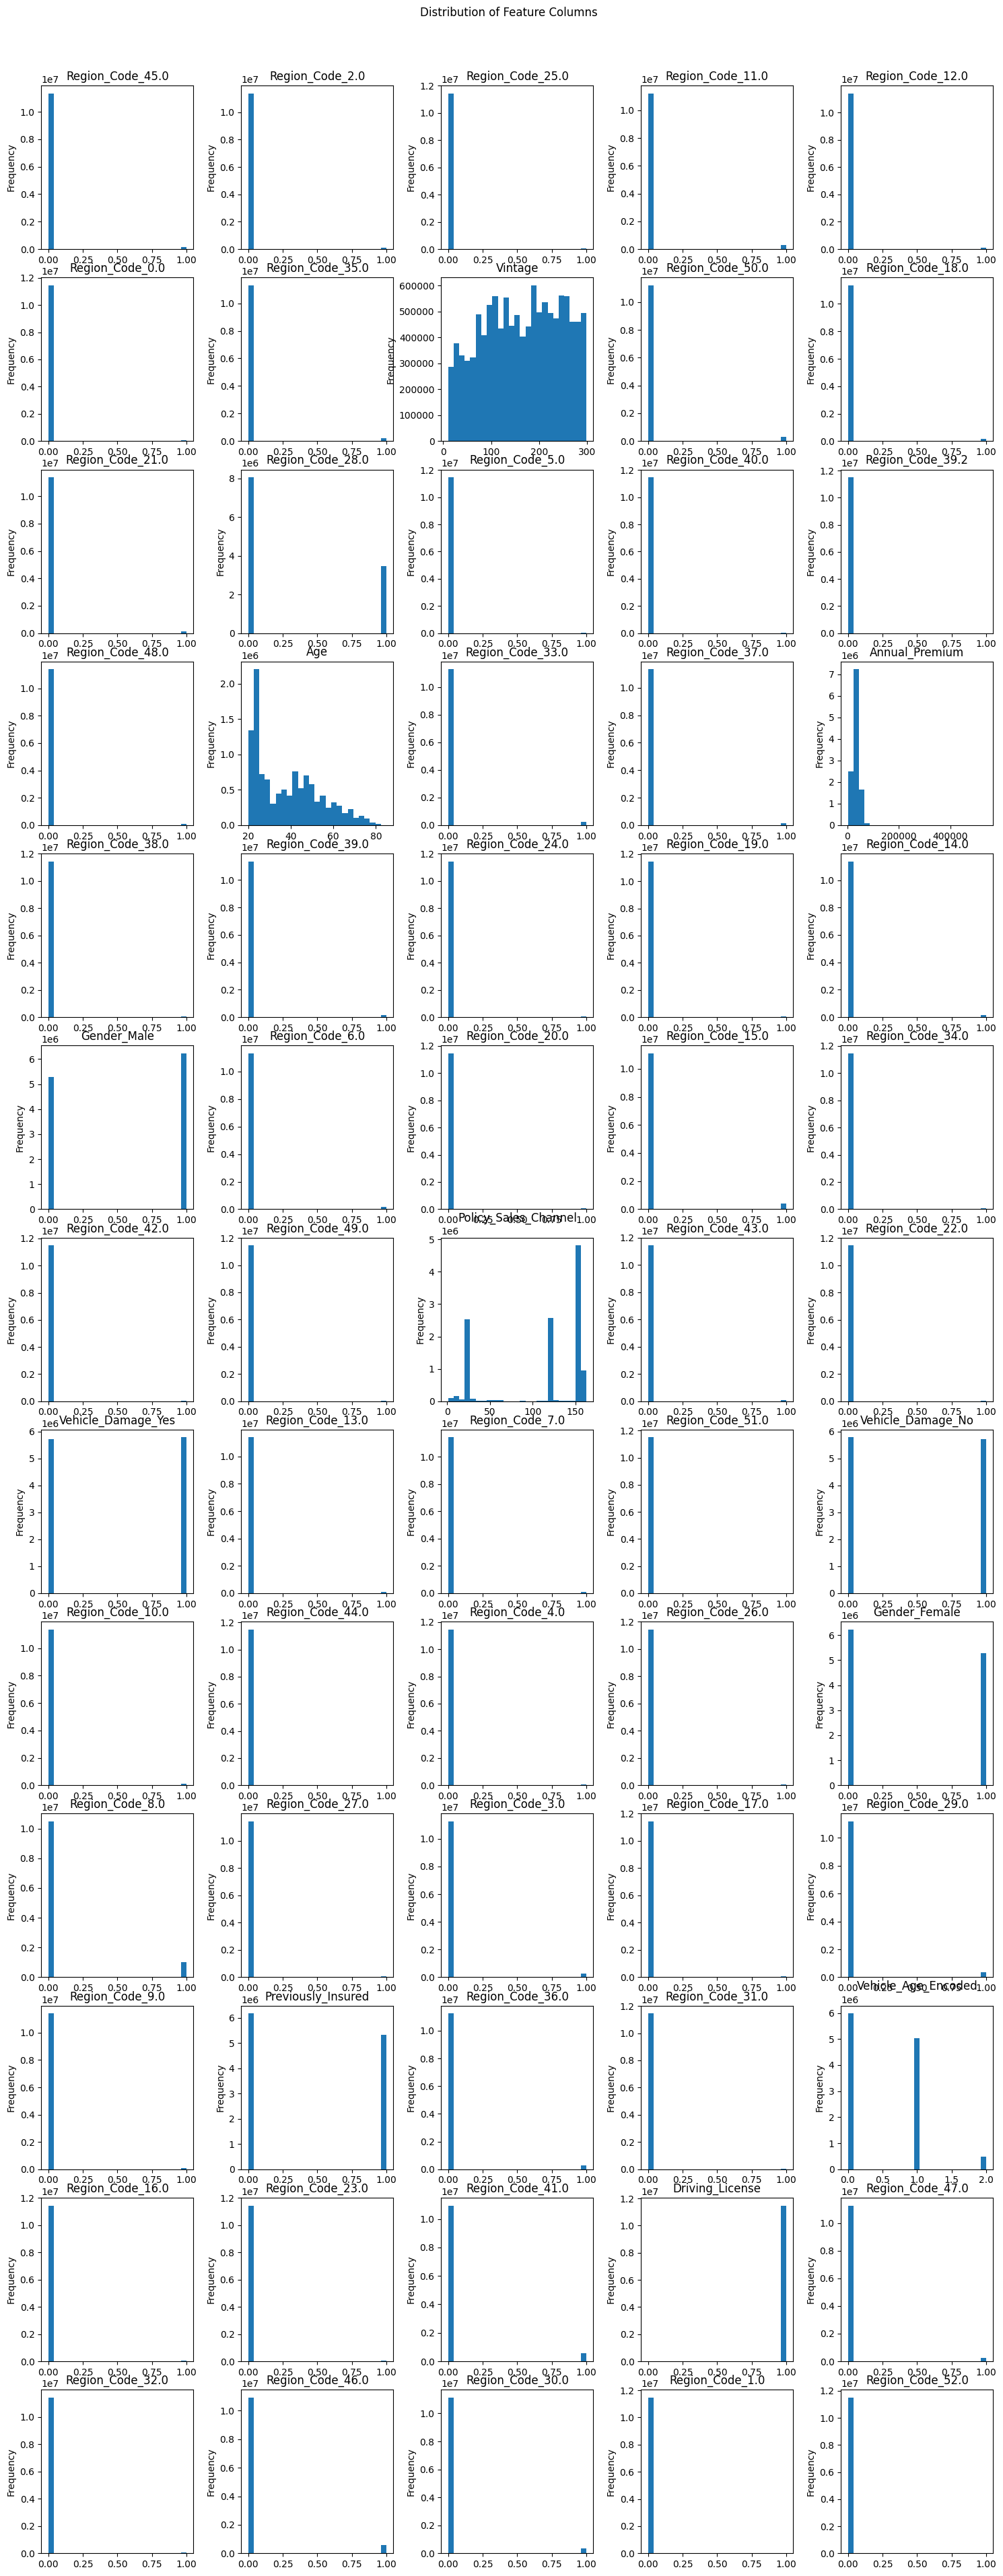

In [33]:
def plot_features_distribution(df, TARGET):

    feature_columns = set(df.columns)-set([TARGET])

    # Define the number of rows and columns for subplots
    num_rows = (len(feature_columns) + 4) // 5
    num_cols = min(len(feature_columns), 5)

    # Create subplots
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

    fig.subplots_adjust(wspace=0.3, hspace=0.5,top=0.90, bottom=0.3)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)

    # Iterate through feature columns and plot their distributions
    for i, col in enumerate(feature_columns):
        row = i // num_cols
        col_num = i % num_cols
        ax = axes[row, col_num]

        # Plot the distribution
        df[col].plot(kind='hist', ax=ax, bins=25, title=col)
        ax.set_ylabel('Frequency')

    # If there are empty subplots, remove them
    for i in range(len(feature_columns), num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

    # Add a title to the overall picture
    plt.suptitle("Distribution of Feature Columns")
    # Show the plot
    plt.show()

plot_features_distribution(train_data, TARGET)


### Correlations

In [34]:
#### Correlation matrix
correlation_matrix = train_data.corr(method="spearman") # To capture non linear correlations
plt.figure(figsize=(17, 13))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

#### Analysis target distribution across features


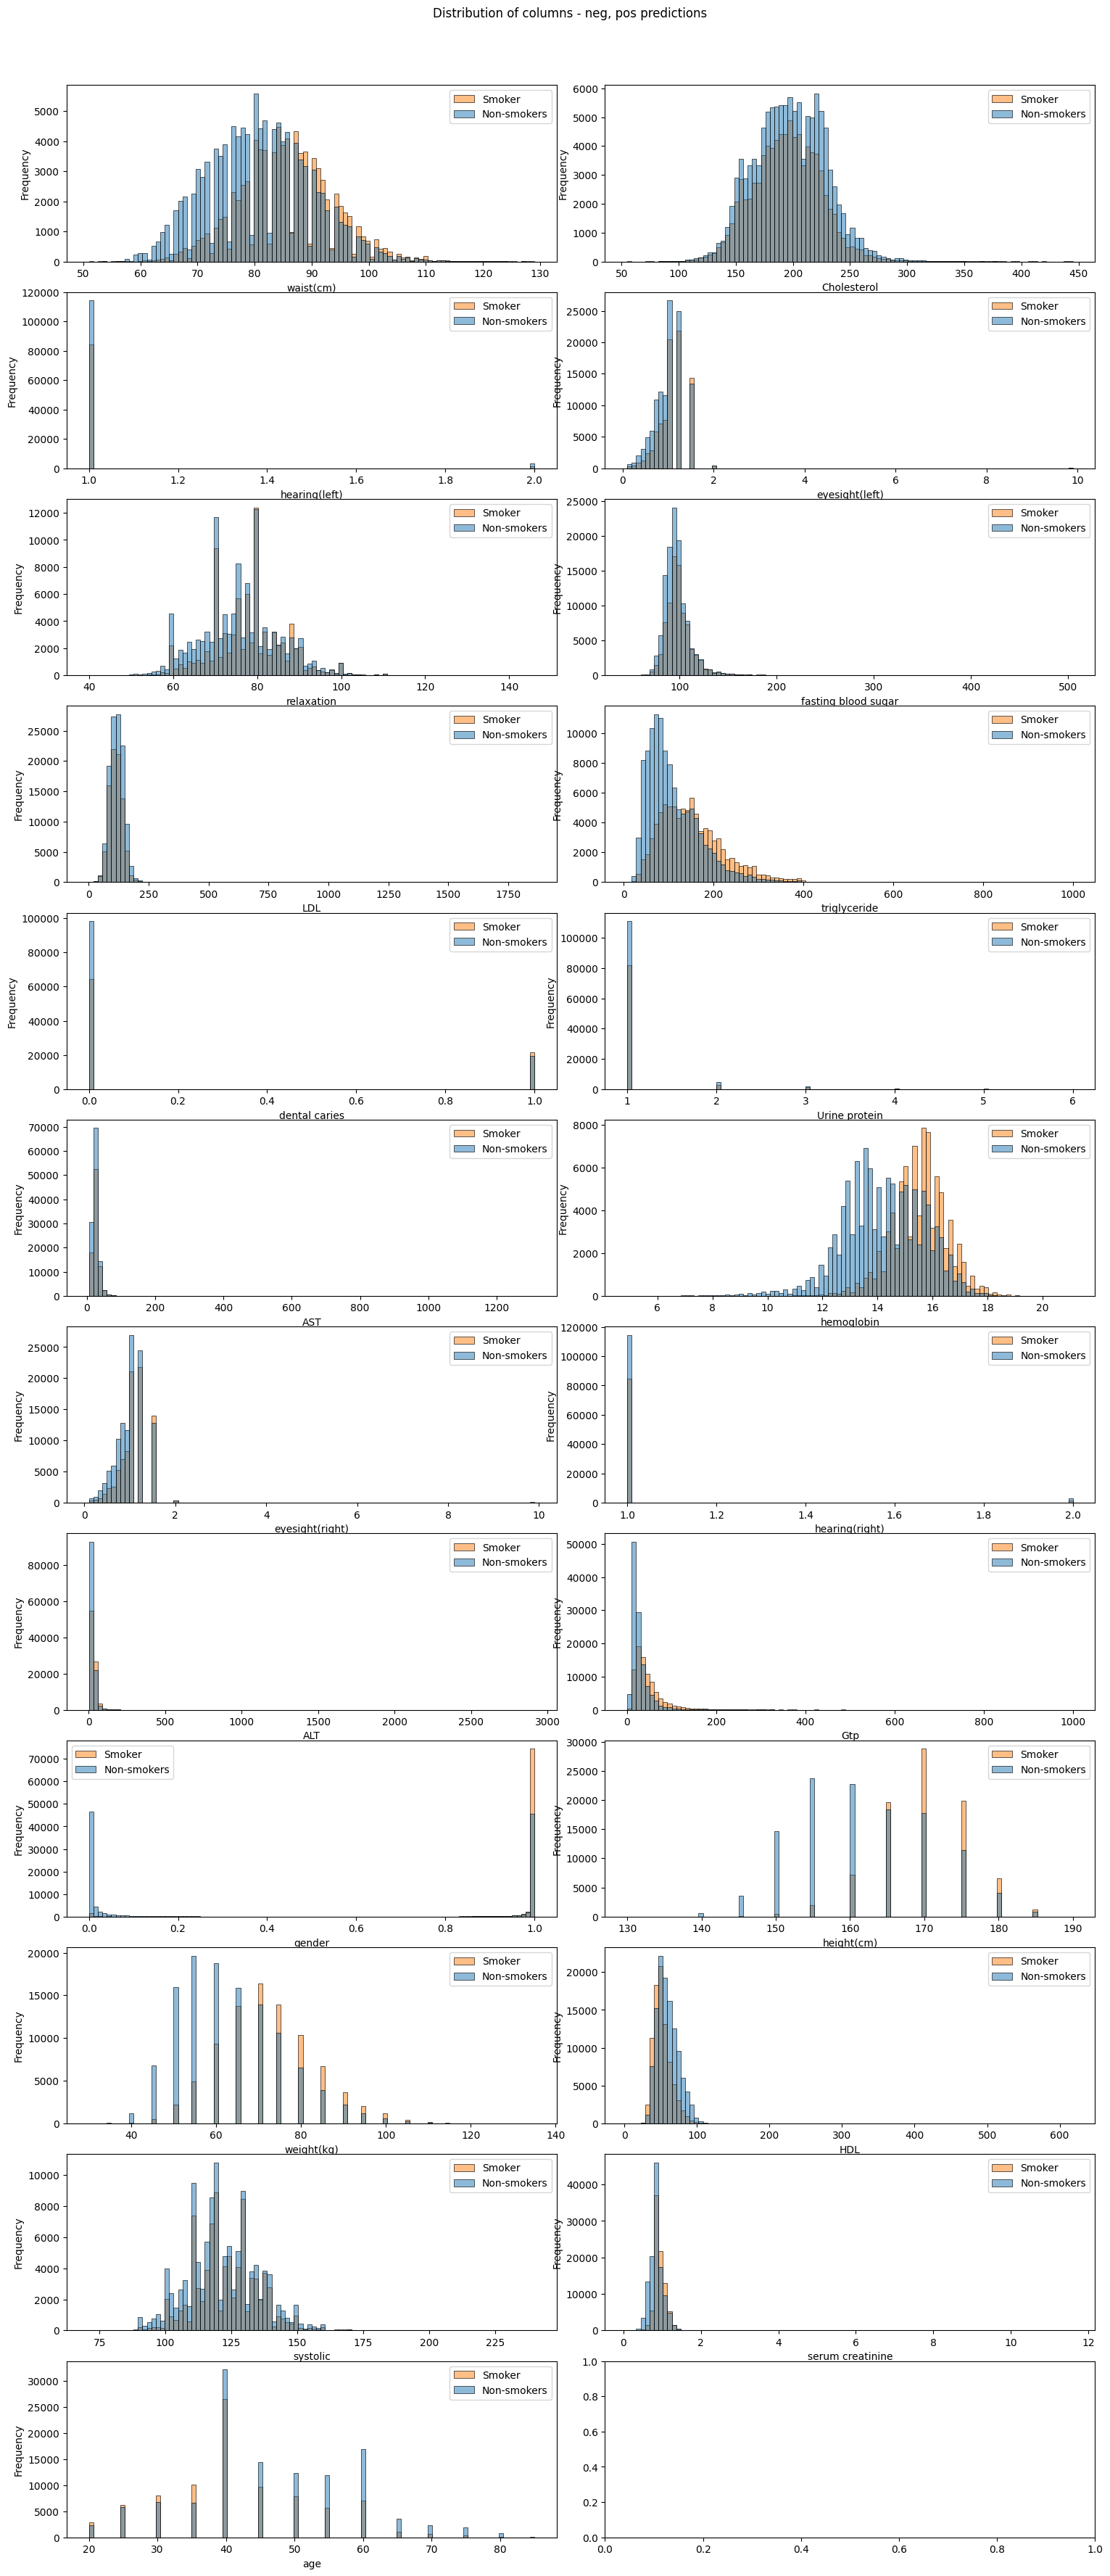

In [ ]:
def plot_target_distribution(df, TARGET, FEATURES):

    feature_columns = FEATURES

    negative_pred = df[abs(df[TARGET])<=0.5]
    positive_pred = df[abs(df[TARGET])>0.5]

    # Define the number of rows and columns for subplots
    num_rows = (len(feature_columns) + 1) // 2
    num_cols = min(len(feature_columns), 2)

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

    fig.subplots_adjust(wspace=0.3, hspace=0.5,top=0.95, bottom=0.3)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)

    # Iterate through feature columns and plot their distributions
    for i, col in enumerate(feature_columns):
        row = i // num_cols
        col_num = i % num_cols
        ax = axes[row, col_num]

        # Plot the distribution
        # positive_pred[col].plot(kind='hist', ax=ax, bins=100, title=col)
        # negative_pred[col].plot(kind='hist', ax=ax, bins=100, title=col)
        
        sns.histplot(ax = ax, data = df, x=col, hue=TARGET, element="bars", bins = 100)
        ax.set_ylabel('Frequency')
        ax.legend(['Smoker', 'Non-smokers'])

    # Add a title to the overall picture
    plt.suptitle("Distribution of columns - neg, pos predictions")
    # Show the plot
    plt.show()

plot_target_distribution(train_data, TARGET, FEATURES)

### Observations
Some variables are particularly correlated with smoking:
- height, weight, waist, triglyceride, hemoglobin, Gtp (positively), age and HDL (negatively)
- many variables are normally distributed without transformations
- several variables are binned
- Consider removing highly correlated variables: "Cholesterol", "systolic", "eyesight(right)", "waist(cm)", "AST" or transform them
- There seems to be a strong differences in the distrbutions of smoking/non-smoking for the following features: Hemoglobin, waist, HDL and triglyceride, dental caries
- Gender is an important variable missing here, but present in the original dataset. Its role is partially visible in variables like height and weight (men are on average taller and heavier)

## Feature engineering

#### Let's try to include gender as variable

We use the original dataset to build a model to assign gender given the other variable in this competition dataset

In [27]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate

smoking_data_original = pd.read_csv("data/smoking_dataset.csv",index_col='ID')

kfold = RepeatedStratifiedKFold(n_splits=10,n_repeats=5)
X_0 = smoking_data_original.drop(['gender','oral','tartar','smoking'],axis=1)
y_0 = smoking_data_original['gender'].map({'F':0,'M':1})

results = cross_validate(xgb.XGBClassifier(n_jobs=4,random_state=0),
                         X_0,y_0,
                         scoring='roc_auc',
                         cv=kfold,n_jobs=1,
                         return_estimator=True)

results['test_score'].mean(), results['test_score'].std()


KeyboardInterrupt: 

In [ ]:
### Add it back to train and test data
cols = list(test_data_original.columns)

train_data['gender'] = 0
for clf in results['estimator']:
    train_data['gender'] += clf.predict_proba(train_data[cols])[:,1]
train_data['gender'] /= len(results['estimator'])


test_data['gender'] = 0
for clf in results['estimator']:
    test_data['gender'] += clf.predict_proba(test_data[cols])[:,1]
test_data['gender'] /= len(results['estimator'])


TypeError: no numeric data to plot

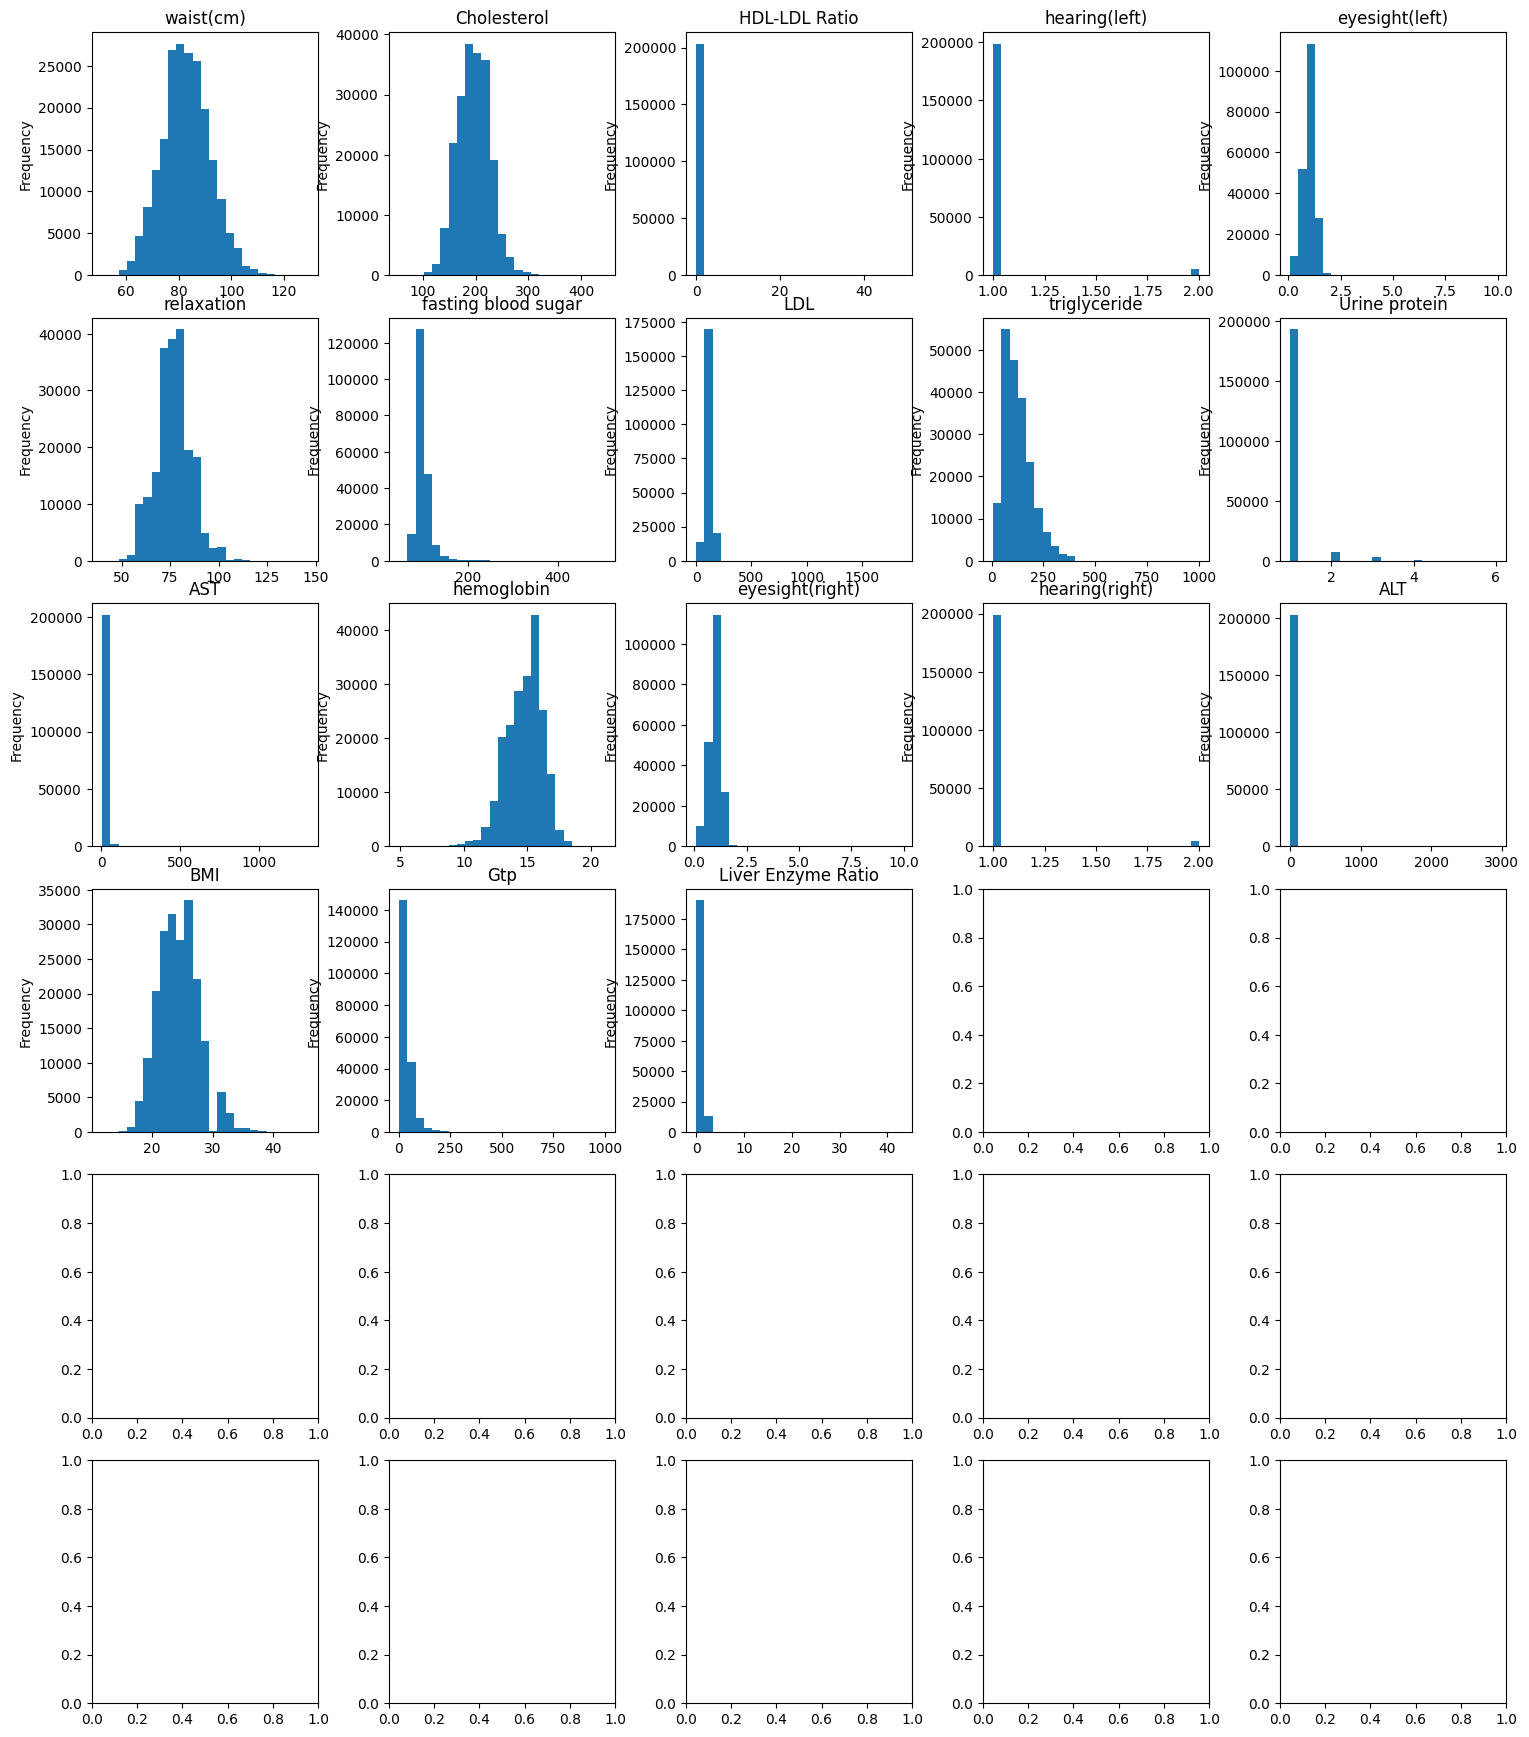

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import yeojohnson

def edit_X_features(df):

    features_df = df.columns
    df = df.copy()

    # ## Create new features
    df["BMI"] = df['weight(kg)']/(df['height(cm)']/100)**2
    df["HDL-LDL Ratio"] = df["HDL"] / df["LDL"]
    df["Liver Enzyme Ratio"] = df["AST"] / df["ALT"]


    ## Trasform original variables 
    # df = np.sqrt(df)
    # df =  np.log10(df+1)
    # df_new = df_new.apply(lambda x: yeojohnson(x)[0])

    # scaler = MinMaxScaler()
    # scaled_data = scaler.fit_transform(df_new)
    # df_new = pd.DataFrame(scaled_data, columns=df_new.columns,  index=df.index)

    return df

full_enhanced=  edit_X_features(train_data[FEATURES+["gender"]])
plot_features_distribution(full_enhanced)


In [ ]:
#### Correlation matrix
correlation_matrix = full_enhanced.corr(method="spearman") # To capture non linear correlations
plt.figure(figsize=(17, 13))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

NameError: name 'full_enhanced' is not defined

## Modelling
Split the data into train and validation set, stratify since dataset is unbalanced

In [28]:
VARIABLES_TO_REMOVE =  []
FEATURES = list(set(FEATURES)-set(VARIABLES_TO_REMOVE))


In [29]:
y = train_data.copy()[TARGET].astype(int)

X_test = test_data[FEATURES].copy()
X = train_data.copy()[FEATURES]

# X_test = edit_X_features(X_test)
# X = edit_X_features(train_data.copy()[FEATURES])

# Single split
train_X, val_X, train_y, val_y = train_test_split(X,y,stratify=y,test_size=0.05,random_state=0)

### Cross validation strategy

In [30]:
nr_folds = 10
kfold = KFold(n_splits=nr_folds,shuffle=True,random_state=0)
skfold = StratifiedKFold(n_splits=nr_folds,shuffle=True,random_state=0)

### Simple logistic regression

In [31]:
log_parameters = {
                'class_weight':class_weights,
                }            

def logistic_predictions(train_X, train_y):

    reg = LogisticRegression(max_iter=10000, **log_parameters)
    
    reg.fit(train_X,train_y)
    predictions_train = reg.predict_proba(train_X)[:,1]
    predictions_train[predictions_train>1]=1
    predictions_train[predictions_train<0]=0
    print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

    predictions = reg.predict_proba(val_X)[:,1]
    predictions[predictions>1]=1
    predictions[predictions<0]=0
    print("ROC-AUC score validation", roc_auc_score(val_y,predictions))
    
    return predictions, reg

log_predictions_val, log_model = logistic_predictions(train_X, train_y)

ROC-AUC score training 0.8174400895484375
ROC-AUC score validation 0.8170713857047847


### I) XGB Classifier

In [23]:
OPTUNA = False

xgb_params = {'n_estimators'          : 2048,
          'max_depth'             : 9,
          'learning_rate'         : 0.05,
          'booster'               : 'gbtree',
          'subsample'             : 0.75,
          'colsample_bytree'      : 0.30,
          'reg_lambda'            : 1.00,
          'reg_alpha'             : 1.00,
          'gamma'                 : 1.00,
          'random_state'          : 0,
          'objective'             : 'binary:logistic',
          'tree_method'           : 'gpu_hist',
          'eval_metric'           : 'auc',
          'n_jobs'                : -1,
         }

def XGBoost_predictions(train_X, train_y, val_X, val_y, xgb_params, optuna):

    reg = xgb.XGBClassifier(**xgb_params)
    reg.fit(train_X,train_y)

    predictions_train = reg.predict_proba(train_X)[:,1]
    predictions_train[predictions_train>1]=1
    predictions_train[predictions_train<0]=0
    print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

    predictions = reg.predict_proba(val_X)[:,1]
    predictions[predictions>1]=1
    predictions[predictions<0]=0
    print("ROC-AUC score validation", roc_auc_score(val_y,predictions))

    val_auc = roc_auc_score(val_y,predictions)

    if optuna == False:
        # for the final prediction, fit model on train + validation set
        reg.fit(pd.concat([train_X, val_X]),pd.concat([train_y, val_y]))

    return predictions, reg, val_auc


if OPTUNA:
    # Use optuna library for optimizing multiple hyper parameters
    def xgb_objective(trial):

        # Set the hyperparameters of the XGBoost classifier.
        params = {'objective':'binary:logistic', 
                  'n_estimators':trial.suggest_int('n_estimators',50,1000),
                  'learning_rate':trial.suggest_float('learning_rate',0.03,0.3),
                  'tree_method':'hist',
                  'max_depth':None,
                  'gamma':trial.suggest_int('gamma',0,15),
                #   'scale_pos_weight':negative_def/positive_def,
                  'random_state':0
                 }

        xgb_auc_score_avg = 0
        for idx, (train_idx,val_idx) in enumerate(skfold.split(X,y)):

            print("Running fold ", idx)
            train_X_fold = X.iloc[train_idx]
            val_X_fold = X.iloc[val_idx]
            train_y_fold = y[train_idx]
            val_y_fold = y[val_idx]

            xgb_predictions_fold, xgb_model_fold, xgb_val_auc_fold = XGBoost_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, params, True)
            xgb_auc_score_avg += xgb_val_auc_fold
            
        xgb_auc_score_avg /=nr_folds
        # print(f'The averaged AUC score evaluated on the validation subset using XGB model:', xgb_auc_score_avg)
        return -xgb_auc_score_avg

    xgb_study = optuna.create_study()
    xgb_study.optimize(xgb_objective, n_trials=100, show_progress_bar=True, n_jobs=10)
    best_xgb_params = xgb_study.best_trial.params

    print('Best XGB hyper parameters:', best_xgb_params)


if OPTUNA == True:
    xgb_params = best_xgb_params

xgb_predictions_val, xgb_model, xgb_val_auc = XGBoost_predictions(train_X, train_y,val_X, val_y, xgb_params, False)
#xgb_model.score


ROC-AUC score training 0.9802654399737777
ROC-AUC score validation 0.8691393086221115


### II) Random forest classifier

In [ ]:
# OPTUNA = False

# rf_params = { 'n_estimators':883,
#               'max_depth':14,
#               'min_samples_split':5,
#               'class_weight':class_weights,
#               'random_state':0,
#               'bootstrap':True,
#               'n_jobs' :-1}

# # rf_params = { 'n_estimators':935,
# #               'max_depth':10,
# #               'min_samples_split':3,
# #               'class_weight':class_weights,
# #               'random_state':0,
# #               'bootstrap':True,
# #               'n_jobs' :-1}

# def RandomForest_predictions(train_X, train_y, val_X, val_y, rf_params, optuna):

#     reg = RandomForestClassifier(**rf_params)
#     reg.fit(train_X,train_y)

#     predictions_train = reg.predict_proba(train_X)[:,1]
#     predictions_train[predictions_train>1]=1
#     predictions_train[predictions_train<0]=0
#     print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

#     predictions = reg.predict_proba(val_X)[:,1]
#     predictions[predictions>1]=1
#     predictions[predictions<0]=0
#     print("ROC-AUC score validation", roc_auc_score(val_y,predictions))

#     val_auc = roc_auc_score(val_y,predictions)

#     if optuna == False:
#         # for the final prediction, fit model on train + validation set
#         reg.fit(pd.concat([train_X, val_X]),pd.concat([train_y, val_y]))

#     return predictions, reg, val_auc

# if OPTUNA:
#     # Use optuna library for optimizing multiple hyper parameters
#     def rf_objective(trial):

#         # Set the hyperparameters of the Random forest classifier.
#         params = {'n_estimators':trial.suggest_int('n_estimators',200,1000),
#               'max_depth':trial.suggest_int('max_depth',1,15),
#               'min_samples_split':trial.suggest_int('min_samples_split',2,7),
#               'class_weight':class_weights,
#               'random_state':0,
#               'bootstrap':True,
#               'n_jobs' :-1}

#         rf_auc_score_avg = 0
#         for idx, (train_idx,val_idx) in enumerate(skfold.split(X,y)):

#             print("Running fold ", idx)
#             train_X_fold = X.iloc[train_idx]
#             val_X_fold = X.iloc[val_idx]
#             train_y_fold = y[train_idx]
#             val_y_fold = y[val_idx]

#             rf_predictions_fold, rf_model_fold, rf_val_auc_fold = RandomForest_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, params, True)
#             rf_auc_score_avg += rf_val_auc_fold
            
#         rf_auc_score_avg /=nr_folds
#         # print(f'The averaged AUC score evaluated on the validation subset using RF model:', rf_auc_score_avg)
#         return -rf_auc_score_avg

#     rf_study = optuna.create_study()
#     rf_study.optimize(rf_objective, n_trials=10, n_jobs=10, show_progress_bar=True)
#     best_rf_params = rf_study.best_trial.params

#     print('Best RF hyper parameters:', best_rf_params)

# if OPTUNA == True:
#     rf_params = best_rf_params

# random_forest_predictions_val, rf_model, rf_val_auc = RandomForest_predictions(train_X, train_y, val_X, val_y, rf_params, False)

### III) ExtraTreesClassifier

In [59]:
OPTUNA = False

et_params = { 'n_estimators':1000,
              'max_depth':30,
              'max_features':15,
              'min_samples_split':50,
              'min_samples_leaf':10,
            #   'class_weight':class_weights,
              'random_state':0,
              'bootstrap':False,
              'n_jobs' :-1}

def ExtraTrees_predictions(train_X, train_y, val_X, val_y, et_params, optuna):

    reg = ExtraTreesClassifier(**et_params)
    reg.fit(train_X,train_y)

    predictions_train = reg.predict_proba(train_X)[:,1]
    predictions_train[predictions_train>1]=1
    predictions_train[predictions_train<0]=0
    print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

    predictions = reg.predict_proba(val_X)[:,1]
    predictions[predictions>1]=1
    predictions[predictions<0]=0
    print("ROC-AUC score validation", roc_auc_score(val_y,predictions))

    val_auc = roc_auc_score(val_y,predictions)

    if optuna == False:
        # for the final prediction, fit model on train + validation set
        reg.fit(pd.concat([train_X, val_X]),pd.concat([train_y, val_y]))

    return predictions, reg, val_auc


if OPTUNA:
    # Use optuna library for optimizing multiple hyper parameters
    def extratree_objective(trial):

        # Set the hyperparameters of the Random forest classifier.
        params = {'n_estimators':trial.suggest_int('n_estimators',100,1000),
              'max_depth':trial.suggest_int('max_depth',1,100),
              'max_features':'auto',
              'min_samples_split':trial.suggest_int('min_samples_split',2,10),
              'min_samples_leaf':trial.suggest_int('min_samples_leaf',1,10),
              'class_weight':class_weights,
              'random_state':0,
              'bootstrap':False,
              'n_jobs' :-1}
        
        et_auc_score_avg = 0
        for idx, (train_idx,val_idx) in enumerate(skfold.split(X,y)):

            print("Running fold ", idx)
            train_X_fold = X.iloc[train_idx]
            val_X_fold = X.iloc[val_idx]
            train_y_fold = y[train_idx]
            val_y_fold = y[val_idx]

            et_predictions_fold, et_model_fold, et_val_auc_fold = ExtraTrees_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, params, True)
            et_auc_score_avg += et_val_auc_fold
            
        et_auc_score_avg /=nr_folds
        # print(f'The averaged AUC score evaluated on the validation subset using RF model:', rf_auc_score_avg)
        return -et_auc_score_avg

    et_study = optuna.create_study()
    et_study.optimize(extratree_objective, n_trials=20, n_jobs=10, show_progress_bar=True)
    best_et_params = et_study.best_trial.params

    print('Best Extratree hyper parameters:', best_et_params)

if OPTUNA == True:
    et_params=best_et_params
    
extratree_classifier_predictions_val, extratree_model, extrateree_val_auc = ExtraTrees_predictions(train_X, train_y, val_X, val_y, et_params, False)

ROC-AUC score training 0.9222954493707467
ROC-AUC score validation 0.8567719277192615


### IV) Logistic regression with Nyström kernel approximation

In [ ]:
# OPTUNA = False
# nystroem_params = {'n_components':2000}

# def nystroem_logistic(train_X, train_y, val_X, val_y, nystroem_params, optuna):

#     # Standardize the features (optional but recommended)
#     scaler = StandardScaler()
#     X_train = scaler.fit_transform(train_X)
#     X_test = scaler.transform(val_X)

#     # Create a Nystroem feature map
#     nystroem = Nystroem(kernel='rbf', **nystroem_params, random_state=42)

#     # Apply the feature map to both the training and testing data
#     X_train_nystroem = nystroem.fit_transform(X_train)
#     X_test_nystroem = nystroem.transform(X_test)

#     # Create and train the logistic regression model
#     reg = LogisticRegression()
#     reg.fit(X_train_nystroem, train_y)

#     # Make predictions on the test set
#     predictions_train = reg.predict_proba(X_train_nystroem)[:,1]

#     predictions_train[predictions_train>1]=1
#     predictions_train[predictions_train<0]=0
#     print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

#     predictions = reg.predict_proba(X_test_nystroem)[:,1]
#     predictions[predictions>1]=1
#     predictions[predictions<0]=0
#     print("ROC-AUC score validation", roc_auc_score(val_y,predictions))

#     val_auc = roc_auc_score(val_y,predictions)

#     if optuna == False:
#         # for the final prediction, fit model on train + validation set
#         X_train_nystroem_full = nystroem.fit_transform(pd.concat([train_X, val_X]))
#         reg.fit(X_train_nystroem_full,pd.concat([train_y, val_y]))

#     return predictions, reg, val_auc

# if OPTUNA:
#     # Use optuna library for optimizing multiple hyper parameters
#     def nystroem_objective(trial):
#         params = {'n_components':trial.suggest_int('n_components',50,500)}        
        
#         ny_auc_score_avg = 0
#         for idx, (train_idx,val_idx) in enumerate(skfold.split(X,y)):
            
#             print("Running fold ", idx)
#             train_X_fold = X.iloc[train_idx]
#             val_X_fold = X.iloc[val_idx]
#             train_y_fold = y[train_idx]
#             val_y_fold = y[val_idx]

#             ny_predictions_fold, ny_model_fold, ny_val_auc_fold = nystroem_logistic(train_X_fold, train_y_fold, val_X_fold, val_y_fold, params, True)
#             ny_auc_score_avg += ny_val_auc_fold
            
#         ny_auc_score_avg /=nr_folds
#         # print(f'The averaged AUC score evaluated on the validation subset using RF model:', rf_auc_score_avg)
#         return -ny_auc_score_avg

#     ny_study = optuna.create_study()
#     ny_study.optimize(nystroem_objective, n_trials=10, n_jobs=10, show_progress_bar=True)
#     best_ny_params = ny_study.best_trial.params

#     print('Best nystroem logistic hyper parameters:', best_ny_params)

# if OPTUNA ==True:
#     nystroem_params=best_ny_params
    
# # nystroem_params = best_ny_params
# nystroem_logistic_predictions_val, nystroem_logistic_model, nystroem_val_auc_fold = nystroem_logistic(train_X, train_y, val_X, val_y, nystroem_params, False)

### V) CatBoostClassifier

In [24]:
OPTUNA = False

cb_params = {
            'iterations': 1250,
            'depth':6,
            'learning_rate': 0.10220287159013668,
            'l2_leaf_reg': 1,
            'loss_function':'Logloss',
            'silent':True,
            'random_seed':42,
            'class_weights':class_weights
            }

def CatBoost_predictions(train_X, train_y, val_X, val_y, cb_params, optuna):

    reg = CatBoostClassifier(**cb_params)    
    reg.fit(train_X,train_y)

    predictions_train = reg.predict_proba(train_X)[:,1]
    predictions_train[predictions_train>1]=1
    predictions_train[predictions_train<0]=0
    print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

    predictions = reg.predict_proba(val_X)[:,1]
    predictions[predictions>1]=1
    predictions[predictions<0]=0
    print("ROC-AUC score validation", roc_auc_score(val_y,predictions))
    
    val_auc = roc_auc_score(val_y,predictions)

    if optuna == False:
        # for the final prediction, fit model on train + validation set
        reg.fit(pd.concat([train_X, val_X]),pd.concat([train_y, val_y]))

    return predictions, reg, val_auc

if OPTUNA:
    # Use optuna library for optimizing multiple hyper parameters
    def catboost_objective(trial):

        # Set the hyperparameters of the Random forest classifier.

        params = {'iterations':trial.suggest_int('iterations',500, 2000),
              'depth':trial.suggest_int('depth',1,10),
              'learning_rate':trial.suggest_float('learning_rate',0.01,0.3),
              'l2_leaf_reg':trial.suggest_int('l2_leaf_reg',1,10),
              'loss_function':'Logloss',
              'random_seed':42,
              'class_weights':class_weights
              }
        
        cb_auc_score_avg = 0
        for idx, (train_idx,val_idx) in enumerate(skfold.split(X,y)):

            print("Running fold ", idx)
            train_X_fold = X.iloc[train_idx]
            val_X_fold = X.iloc[val_idx]
            train_y_fold = y[train_idx]
            val_y_fold = y[val_idx]

            cb_predictions_fold, cb_model_fold, cb_val_auc_fold = CatBoost_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, params, True)
            cb_auc_score_avg += cb_val_auc_fold
            
        cb_auc_score_avg /=nr_folds
        # print(f'The averaged AUC score evaluated on the validation subset using RF model:', rf_auc_score_avg)
        return -cb_auc_score_avg

    cb_study = optuna.create_study()
    cb_study.optimize(catboost_objective, n_trials=50, n_jobs=10, show_progress_bar=True)
    best_cb_params = cb_study.best_trial.params

    print('Best catboost hyper parameters:', best_cb_params)

if OPTUNA == True:
    cb_params=best_cb_params

catbost_classifier_predictions_val, catboost_model, catboost_val_auc = CatBoost_predictions(train_X, train_y, val_X, val_y, cb_params, True)

ROC-AUC score training 0.902479241351444
ROC-AUC score validation 0.8675247079981795


#### Feature importance

Text(0.5, 1.0, 'Feature Importance')

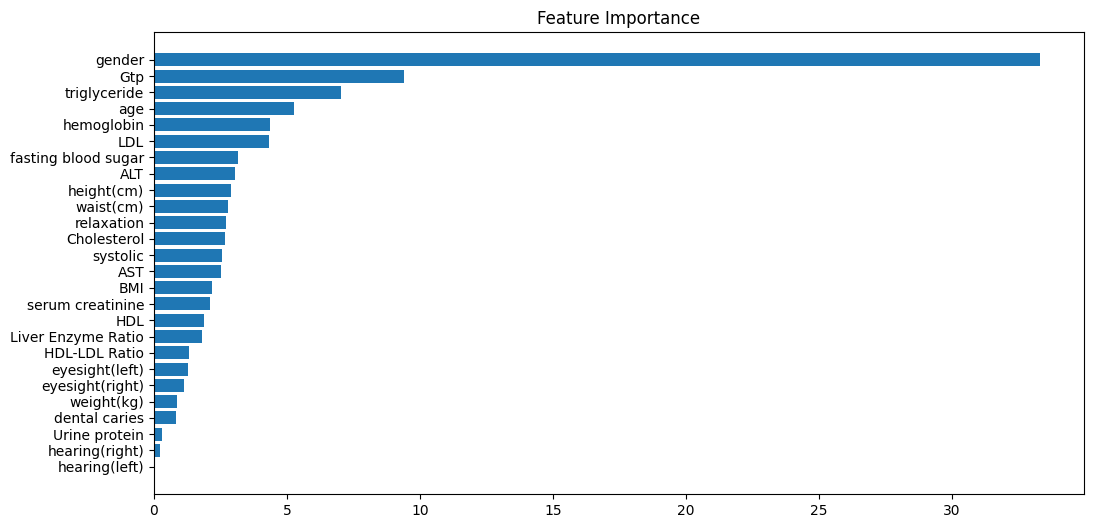

In [25]:
feature_importance = catboost_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')


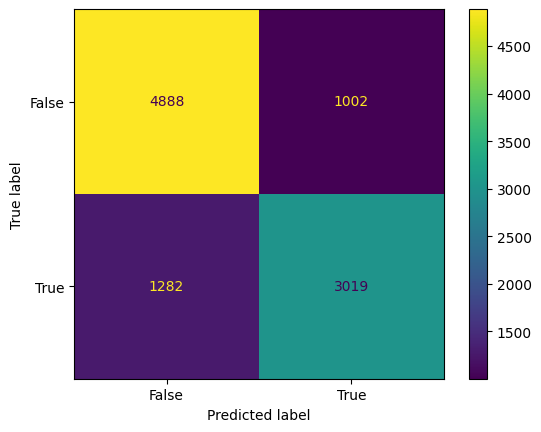

In [26]:
predictions_conf = [0 if x < 0.5 else 1 for x in catbost_classifier_predictions_val]
predictions_conf

confusion_matrix = metrics.confusion_matrix(val_y, predictions_conf)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

### VI) LGBMClassifier

In [27]:
OPTUNA = False

lgbm_params = {
              'boosting_type':'gbdt',
              'num_leaves':108,
              'learning_rate':0.02116145429539354,
              'n_estimators':1653,
              'max_depth':8,
              'random_state':42,
              'class_weight':class_weights
              }

def lgbm_predictions(train_X, train_y, val_X, val_y, lgbm_params, optuna):

    reg = lgb.LGBMClassifier(**lgbm_params)    
    reg.fit(train_X,train_y)

    predictions_train = reg.predict_proba(train_X)[:,1]
    predictions_train[predictions_train>1]=1
    predictions_train[predictions_train<0]=0
    print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

    predictions = reg.predict_proba(val_X)[:,1]
    predictions[predictions>1]=1
    predictions[predictions<0]=0
    print("ROC-AUC score validation", roc_auc_score(val_y,predictions))
    
    val_auc = roc_auc_score(val_y,predictions)

    if optuna == False:
        # for the final prediction, fit model on train + validation set
        reg.fit(pd.concat([train_X, val_X]),pd.concat([train_y, val_y]))

    return predictions, reg, val_auc

if OPTUNA:
    # Use optuna library for optimizing multiple hyper parameters
    def lgbm_objective(trial):

        # Set the hyperparameters of the Random forest classifier.    
        params = { 'boosting_type':'gbdt',
              'num_leaves':trial.suggest_int('num_leaves',10, 200),
              'learning_rate':trial.suggest_float('learning_rate',0.01,0.3),
              'n_estimators':trial.suggest_int('n_estimators',100, 2000),
              'max_depth':-1,
              'random_state':42,
              'class_weight':class_weights
              }
        
        lgbm_auc_score_avg = 0
        for idx, (train_idx,val_idx) in enumerate(skfold.split(X,y)):

            print("Running fold ", idx)
            train_X_fold = X.iloc[train_idx]
            val_X_fold = X.iloc[val_idx]
            train_y_fold = y[train_idx]
            val_y_fold = y[val_idx]

            lgbm_predictions_fold, lgbm_model_fold, lgbm_val_auc_fold = lgbm_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, params, True)
            lgbm_auc_score_avg += lgbm_val_auc_fold
            
        lgbm_auc_score_avg /=nr_folds
        # print(f'The averaged AUC score evaluated on the validation subset using RF model:', rf_auc_score_avg)
        return -lgbm_auc_score_avg

    lgbm_study = optuna.create_study()
    lgbm_study.optimize(lgbm_objective, n_trials=10, n_jobs=10, show_progress_bar=True)
    best_lgbm_params = lgbm_study.best_trial.params

    print('Best lgbm hyper parameters:', best_lgbm_params)

if OPTUNA == True:
    lgbm_params = best_lgbm_params

lgbm_classifier_predictions_val, lgbm_model, lgbm_val_auc= lgbm_predictions(train_X, train_y, val_X, val_y, lgbm_params, False)

ROC-AUC score training 0.9307235234509549
ROC-AUC score validation 0.867451522506907


### VII) HistGradientBoostingClassifier

In [28]:
OPTUNA = False
hgbc_params =  {'max_iter': 800, 
                'learning_rate': 0.05,#0.12079596267303279, 
                'max_depth': None, 
                'l2_regularization': 0, #0.06731258939148825,
                'random_state':42}

def hgbc_predictions(train_X, train_y, val_X, val_y, hgbc_params, optuna):

    reg = HistGradientBoostingClassifier(**hgbc_params)
    reg.fit(train_X,train_y)

    predictions_train = reg.predict_proba(train_X)[:,1]
    predictions_train[predictions_train>1]=1
    predictions_train[predictions_train<0]=0
    print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

    predictions = reg.predict_proba(val_X)[:,1]
    predictions[predictions>1]=1
    predictions[predictions<0]=0
    print("ROC-AUC score validation", roc_auc_score(val_y,predictions))

    val_auc = roc_auc_score(val_y,predictions)

    if optuna == False:
        # for the final prediction, fit model on train + validation set
        reg.fit(pd.concat([train_X, val_X]),pd.concat([train_y, val_y]))

    return predictions, reg, val_auc

if OPTUNA:
    # Use optuna library for optimizing multiple hyper parameters
    def hgbc_objective(trial):

        # Set the hyperparameters of the Random forest classifier.
           
        params = {
            'max_iter':trial.suggest_int('max_iter',1, 1000),
            'learning_rate':trial.suggest_float('learning_rate',0.01,0.3),
            'max_depth':trial.suggest_int('max_depth',1, 100),
            'random_state':42,
            'l2_regularization':trial.suggest_float('l2_regularization',0, 0.1),
              }
        
        hgbc_auc_score_avg = 0
        for idx, (train_idx,val_idx) in enumerate(skfold.split(X,y)):

            print("Running fold ", idx)
            train_X_fold = X.iloc[train_idx]
            val_X_fold = X.iloc[val_idx]
            train_y_fold = y[train_idx]
            val_y_fold = y[val_idx]

            hgbc_predictions_fold, hgbc_model_fold, hgbc_val_auc_fold = hgbc_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, params, True)
            hgbc_auc_score_avg += hgbc_val_auc_fold
            
        hgbc_auc_score_avg /=nr_folds
        # print(f'The averaged AUC score evaluated on the validation subset using RF model:', rf_auc_score_avg)
        return -hgbc_auc_score_avg

    hgbc_study = optuna.create_study()
    hgbc_study.optimize(hgbc_objective, n_trials=50, n_jobs=10, show_progress_bar=True)
    best_hgbc_params = hgbc_study.best_trial.params

    print('Best hgbc hyper parameters:', best_hgbc_params)

if OPTUNA==True:
    hgbc_params = best_hgbc_params

hgbc_classifier_predictions_val, hgbc_model, hgbc_val_auc = hgbc_predictions(train_X, train_y, val_X, val_y, hgbc_params, False)

ROC-AUC score training 0.8753979251486466
ROC-AUC score validation 0.8644747993616203


### VIII) Neural network

In [29]:
# nn_params =  {"hidden_layer_sizes":(20, 10, 5), 
#               "activation":'relu', 
#               "max_iter":100, 
#               "random_state":42}

# def neural_network_classifier(train_X, train_y, val_X, val_y, nn_params, optuna):
#     # Create an MLPClassifier (Multi-layer Perceptron) neural network
#     # You can customize the architecture by adjusting the hidden_layer_sizes and other parameters.
#     reg = MLPClassifier(**nn_params)

#     # Train the model
#     reg.fit(train_X,train_y)

#     predictions_train = reg.predict_proba(train_X)[:,1]
#     predictions_train[predictions_train>1]=1
#     predictions_train[predictions_train<0]=0
#     print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

#     predictions = reg.predict_proba(val_X)[:,1]
#     predictions[predictions>1]=1
#     predictions[predictions<0]=0
#     print("ROC-AUC score validation", roc_auc_score(val_y,predictions))

#     val_auc = roc_auc_score(val_y,predictions)

#     if optuna == False:
#         # for the final prediction, fit model on train + validation set
#         reg.fit(pd.concat([train_X, val_X]),pd.concat([train_y, val_y]))
    
#     return predictions, reg, val_auc

# nn_classifier_predictions_val, nn_model, nn_val_auc = neural_network_classifier(train_X, train_y, val_X, val_y, nn_params, False)

## Check AUC-ROC

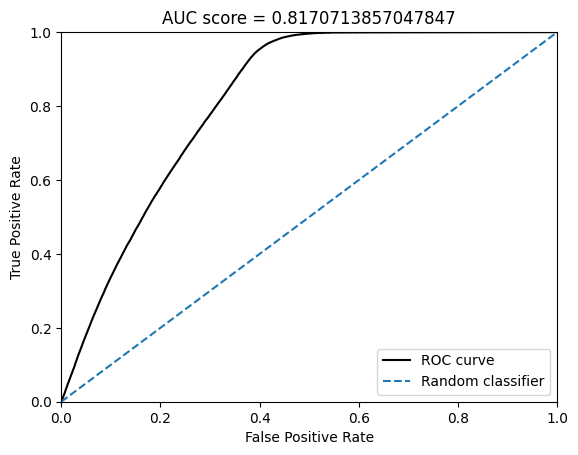

In [32]:
def plot_roc(val_y,pred_y):
    # Plot the ROC curve
    fpr, tpr, _ = roc_curve(val_y,pred_y, pos_label=1)

    plt.plot(fpr, tpr, 'k', label='ROC curve')

    # Plot the baseline
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')

    # Set the axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    # Set axis limits
    plt.xlim(0,1)
    plt.ylim(0,1)

    # Set the title
    plt.title('AUC score = ' + str(roc_auc_score(val_y,pred_y)))

    # Show the legend
    plt.legend()

    # Show the plot
    plt.show()
    
# plot_roc(val_y,xgb_predictions_val)
# plot_roc(val_y,random_forest_predictions)
# plot_roc(val_y,extratree_classifier_predictions)
plot_roc(val_y,log_predictions_val)

### Rank models by performance

In [60]:
val_predictions_roc = {'xgb':roc_auc_score(val_y,xgb_predictions_val),
                    #    'rf':roc_auc_score(val_y,random_forest_predictions_val),
                       'extratree':roc_auc_score(val_y,extratree_classifier_predictions_val),
                       'log':roc_auc_score(val_y,log_predictions_val),
                       'lgbm':roc_auc_score(val_y,lgbm_classifier_predictions_val),
                       'catboost':roc_auc_score(val_y,catbost_classifier_predictions_val),
                       'hgbc':roc_auc_score(val_y,hgbc_classifier_predictions_val),
                    #    'nystroem':roc_auc_score(val_y,nystroem_logistic_predictions_val),     
                    #    'neural':roc_auc_score(val_y,nn_classifier_predictions_val),     
                       }

val_predictions_roc = sorted(val_predictions_roc.items(), key=lambda x:x[1],  reverse=True)
val_predictions_roc


[('xgb', 0.8691393086221115),
 ('catboost', 0.8675247079981795),
 ('lgbm', 0.867451522506907),
 ('hgbc', 0.8644747993616203),
 ('extratree', 0.8567719277192615),
 ('log', 0.8423556885929713)]

### Optimize weights for the ensamble with Optuna (on initial validation set)

In [65]:
# ensamble_weights = [0.25, 0.25, 0.00, 0.25, 0.25, 0.00, 0.00, 0.00] # manual version
ensamble_weights = [0.40, 0.20, 0.20, 0.20] # manual version

'''
model_predictions_val = [xgb_predictions_val, catbost_classifier_predictions_val, nystroem_logistic_predictions_val,
                          hgbc_classifier_predictions_val, lgbm_classifier_predictions_val, random_forest_predictions_val,
                            extratree_classifier_predictions_val, nn_classifier_predictions_val]
'''

model_predictions_val = [xgb_predictions_val, catbost_classifier_predictions_val, 
                          hgbc_classifier_predictions_val, lgbm_classifier_predictions_val,
                          extratree_classifier_predictions_val
                            ]

ensamble_predictions_val = np.average(model_predictions_val, weights=ensamble_weights, axis=0)
roc_auc_score(val_y,ensamble_predictions_val)

0.8689858519892519

In [74]:
if True:

  optuna.logging.set_verbosity(optuna.logging.WARNING)

  def ensamble_objective(trial):
    STEP_SIZE = 2

    upper_limit = 100

    weights = []
    all_models_predictions = []

    w_xgb = trial.suggest_int("w_xgb", 0, upper_limit, step=STEP_SIZE)
    weights.append(w_xgb)

    w_catboost = trial.suggest_int("w_catboost", 0, upper_limit, step=STEP_SIZE)
    weights.append(w_catboost)

    # w_nystroem = trial.suggest_int("w_nystroem", 0, upper_limit, step=STEP_SIZE)
    # weights.append(w_nystroem)

    w_hgbc = trial.suggest_int("w_hgbc", 0, upper_limit, step=STEP_SIZE)
    weights.append(w_hgbc)

    w_lgbm = trial.suggest_int("w_lgbm", 0, upper_limit, step=STEP_SIZE)
    weights.append(w_lgbm)

    # w_rf = trial.suggest_int("w_rf", 0, upper_limit, step=STEP_SIZE)
    # weights.append(w_rf)

    w_extratree = trial.suggest_int("w_extratree", 0, upper_limit, step=STEP_SIZE)
    weights.append(w_extratree)

    # w_neural = trial.suggest_int("w_neural", 0, upper_limit, step=STEP_SIZE)
    # weights.append(w_neural)

    # model_predictions_val = [xgb_predictions_val, catbost_classifier_predictions_val, nystroem_logistic_predictions_val, hgbc_classifier_predictions_val, 
    #                         lgbm_classifier_predictions_val, random_forest_predictions_val, extratree_classifier_predictions_val,nn_classifier_predictions_val]
    
    model_predictions_val = [xgb_predictions_val, catbost_classifier_predictions_val, hgbc_classifier_predictions_val, 
                            lgbm_classifier_predictions_val, extratree_classifier_predictions_val]

    ensamble_predictions_val = np.average(model_predictions_val, weights=weights, axis=0)
    auroc_ensamble_avg = roc_auc_score(val_y,ensamble_predictions_val)

    return -auroc_ensamble_avg


  ensamble_study = optuna.create_study(study_name="optimizing weights")
  ensamble_study.optimize(ensamble_objective, n_trials=1000, show_progress_bar=True)

  best_ensamble_params = ensamble_study.best_trial.params

  print('Best ensamble weights:', best_ensamble_params)

  # best_ensamble_params["w_extratree"]=100-sum(best_ensamble_params.values())

  best_ensamble_params


  0%|          | 0/1000 [00:00<?, ?it/s]

Best ensamble weights: {'w_xgb': 96, 'w_catboost': 46, 'w_hgbc': 16, 'w_lgbm': 34, 'w_extratree': 0}


#### Random optimization

In [ ]:
from tqdm import tqdm

w1_weights, w2_weights, w3_weights = list(), list(), list()
w4_weights, scores = list(), list()

model_predictions_val = [xgb_predictions_val, catbost_classifier_predictions_val, 
                          hgbc_classifier_predictions_val, lgbm_classifier_predictions_val,
                            ]

for i in tqdm(range(0, 1000)):
    
    w1 = np.random.random_sample(size = 1)[0]
    w2 = np.random.random_sample(size = 1)[0]
    w3 = np.random.random_sample(size = 1)[0]
    w4 = np.random.random_sample(size = 1)[0]
    
    w1_weights.append(w1)
    w2_weights.append(w2)
    w3_weights.append(w3)
    w4_weights.append(w4)
    
    pred = w1*xgb_predictions_val + w2*catbost_classifier_predictions_val + w3*lgbm_classifier_predictions_val + w4*hgbc_classifier_predictions_val
    scores_in =  roc_auc_score(list(val_y), pred)
    
    scores.append(np.mean(scores_in))
    
results = pd.DataFrame()
results['w_xgb'] = w1_weights
results['w_cat'] = w2_weights
results['w_lgb'] = w3_weights
results['w_hgbc'] = w4_weights
results['score'] = scores
results = results.sort_values(by = 'score', ascending = False).reset_index(drop = True)
results.head(10)

In [70]:
# Manual ensamble_weights = [0.15, 0.15, 0.15, 0.15, 0.10, 0.05, 0.05, 0.15] ## manual version

# best_ensamble_params = {'w_xgb': 50,
#  'w_catboost': 25,
# #  'w_nystroem': 0,
#  'w_hgbc': 10,
#  'w_lgbm': 25,
# #  'w_rf': 0,
# #  'w_extratree': 0,
# #  'w_neural':0
# }


# best_ensamble_params = {'w_xgb': 46, 'w_catboost': 16, 'w_hgbc': 10, 'w_lgbm': 16}
best_ensamble_params = {'w_xgb': 74, 'w_catboost': 34, 'w_hgbc': 12, 'w_lgbm': 28}

## Final Prediction for test set

In [71]:
xgb_predictions = xgb_model.predict_proba(X_test)[:,1]
# random_forest_predictions = rf_model.predict_proba(X_test)[:,1]
# extratree_classifier_predictions = extratree_model.predict_proba(X_test)[:,1]

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(pd.concat([train_X, val_X]).copy())
# X_test_scaled = scaler.transform(X_test.copy())
# n_components = nystroem_params["n_components"] 
# nystroem = Nystroem(kernel='rbf', n_components=n_components, random_state=42)
# X_train_nystroem = nystroem.fit_transform(X_train_scaled)
# X_test_nystroem = nystroem.transform(X_test_scaled)
# nystroem_logistic_predictions = nystroem_logistic_model.predict_proba(X_test_nystroem)[:,1]

catbost_classifier_predictions = catboost_model.predict_proba(X_test)[:,1]
lgbm_classifier_predictions = lgbm_model.predict_proba(X_test)[:,1]
hgbc_classifier_predictions = hgbc_model.predict_proba(X_test)[:,1]
# nn_classifier_predictions = nn_model.predict_proba(X_test)[:,1]


# model_predictions_test = [xgb_predictions, catbost_classifier_predictions, nystroem_logistic_predictions, 
#                           hgbc_classifier_predictions, lgbm_classifier_predictions, random_forest_predictions, 
#                           extratree_classifier_predictions, nn_classifier_predictions]

model_predictions_test = [xgb_predictions, catbost_classifier_predictions, 
                          hgbc_classifier_predictions, lgbm_classifier_predictions,
                            ]

final_prediction = np.average(model_predictions_test, weights=list(best_ensamble_params.values()), axis=0)
# final_prediction =  np.average([xgb_predictions, random_forest_predictions, extratree_classifier_predictions, catbost_classifier_predictions], axis=0)

# Save predicted results to the competition submission format.
submission = pd.DataFrame({'id':test_data.index, TARGET:final_prediction})
submission = submission.set_index(keys="id")
submission.head(3)

,smoking
id,
159256,0.634065
159257,0.280322
159258,0.341354


### Current prediction

In [37]:
log_predictions = log_model.predict_proba(X_test)[:,1]
final_prediction = log_predictions
submission = pd.DataFrame({'id':test_data.index.astype(np.int32), TARGET:final_prediction.astype(np.float16)})
submission = submission.set_index(keys="id")
submission.head(3)

,Response
id,
11504798,0.002140
11504799,0.048737
11504800,0.083008


### Submit predictions

In [38]:
submission.to_csv('submissions/01.simple_logistic_regression_with_dummies.csv')

### ZIP the submission file

In [40]:
!pip install py7zr

   ---------------------------------------- 0.0/67.8 kB ? eta -:--:--
   ------------------------ --------------- 41.0/67.8 kB 991.0 kB/s eta 0:00:01
   ---------------------------------------- 67.8/67.8 kB 1.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/357.3 kB ? eta -:--:--
   ------ --------------------------------- 61.4/357.3 kB 1.7 MB/s eta 0:00:01
   ---------------- ----------------------- 143.4/357.3 kB 1.7 MB/s eta 0:00:01
   ---------------------- ----------------- 204.8/357.3 kB 1.8 MB/s eta 0:00:01
   ---------------------------------- ----- 307.2/357.3 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 357.3/357.3 kB 1.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/46.2 kB ? eta -:--:--
   ---------------------------------------- 46.2/46.2 kB 1.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/246.0 kB ? eta -:--:--
   ----------- ---------------------------- 71.7/246.0 kB 2.0 MB/s eta 0:00:01
   -


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [41]:
import py7zr

name_submission = "01.simple_logistic_regression_with_dummies"

# Path to your submission file
submission_file_path = f'submissions/{name_submission}.csv'

# Path to save the compressed file
compressed_file_path = f'submissions/{name_submission}.7z'

# Create a 7z archive and add the submission file
with py7zr.SevenZipFile(compressed_file_path, 'w') as archive:
    archive.write(submission_file_path, arcname='submission.csv')

print(f"Compressed file created at: {compressed_file_path}")


Compressed file created at: submissions/01.simple_logistic_regression_with_dummies.7z


In [39]:
import zipfile

def compress_to_zip(input_csv_path, output_zip_path):
    with zipfile.ZipFile(output_zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        zipf.write(input_csv_path, arcname='submission.csv')

name_submission = "01.simple_logistic_regression_with_dummies"

input_csv_path = f'submissions/{name_submission}.csv'
output_zip_path = f'submissions/{name_submission}_zipped.zip'

compress_to_zip(input_csv_path, output_zip_path)

### Additional Considerations
- Standardizing the feature variables does not seem to help the score

## Valuable sources
- Inclusion of gender variable: https://www.kaggle.com/competitions/playground-series-s3e24/discussion/452379
- EDA https://www.kaggle.com/code/oscarm524/ps-s3-ep24-eda-modeling-submission
- Feature engineering: https://www.kaggle.com/competitions/playground-series-s3e24/discussion/450314

